In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

from functools import partial
import numpy as np
from sklearn.datasets import load_sample_image

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# fashion mnist with CNN

## load data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
x_train.shape, y_train.shape

In [ ]:
x_train.flags.writeable, y_train.flags.writeable, \
x_test.flags.writeable, y_test.flags.writeable

In [ ]:
x_train = np.expand_dims(x_train.copy(), axis=-1).astype(np.float)
x_test = np.expand_dims(x_test.copy(), axis=-1).astype(np.float)

In [ ]:
x_train.shape

In [ ]:
x_train.flags.writeable, y_train.flags.writeable, \
x_test.flags.writeable, y_test.flags.writeable

In [ ]:
x_train[0, 4, 15:20, :]

In [ ]:
y_train[:5]

In [ ]:
x_train /= 255.0
x_test /= 255.0

In [ ]:
x_train[0, 4, 15:20, :]

## CNN model

In [ ]:
DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=(3, 3), 
                        activation=tf.keras.activations.relu, 
                        padding='same')
DefaultMaxPool2D = tf.keras.layers.MaxPool2D
DefaultDense = partial(tf.keras.layers.Dense,
                       activation='relu')
OutputDense = partial(tf.keras.layers.Dense,
                      units=10,
                      activation='softmax')
DefaultDropout = partial(tf.keras.layers.Dropout,
                         rate=.5)

### build models

In [ ]:
tf.random.set_seed(42)
inputs = tf.keras.Input(shape=(28, 28, 1))

x = DefaultConv2D(filters=64, kernel_size=7)(inputs)
x = DefaultMaxPool2D()(x)

x = DefaultConv2D(filters=128)(x)
x = DefaultConv2D(filters=128)(x)
x = DefaultMaxPool2D()(x)

x = DefaultConv2D(filters=256)(x)
x = DefaultConv2D(filters=256)(x)
x = DefaultMaxPool2D()(x)

x = tf.keras.layers.Flatten()(x)

x = DefaultDense(units=128)(x)
x = DefaultDropout()(x)

x = DefaultDense(units=64)(x)
x = DefaultDropout()(x)

outputs = OutputDense()(x)

model_fun = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_fun.summary()

In [ ]:
tf.random.set_seed(42)
model_seq = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model_seq.summary()

### compare weights

Let's try to compare weights of some layers in these 2 models. Looks like if we set seed than weights are in fact the same.

In [ ]:
model_fun.layers[:5]

In [ ]:
model_fun.layers[3]

In [ ]:
model_fun.get_layer('conv2d_1')

In [ ]:
w_fun = model_fun.get_layer('conv2d_1').weights[0].numpy()

In [ ]:
w_fun.shape

In [ ]:
w_fun[:, :, 0, 0]

In [ ]:
w_seq = model_seq.get_layer('conv2d_6').weights[0].numpy()

In [ ]:
w_seq.shape

In [ ]:
w_seq[:, :, 0, 0]

### training

In [ ]:
model_fun.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=['accuracy'])

In [ ]:
history = model_fun.fit(x_train, y_train, 
                        epochs=10, 
                        validation_split=.2)

In [ ]:
score = model_fun.evaluate(x_test, y_test)

In [ ]:
score

In [ ]:
x_new = x_test[:10]

In [ ]:
x_new.shape

In [ ]:
y_pred = model_fun.predict(x_new)

In [ ]:
y_pred[:3]

# resnet34

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, 
                        kernel_size=3, 
                        strides=1,
                        padding='same', 
                        use_bias=False)

In [ ]:
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()

In [ ]:
model.add(DefaultConv2D(filters=64,
                        kernel_size=(7, 7),
                        strides=2,
                        input_shape=(224, 224, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                             strides=2,
                             padding='same'))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
    
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

## pretrained models

### load and preprocess images

In [4]:
# load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

In [5]:
images.shape

(2, 427, 640, 3)

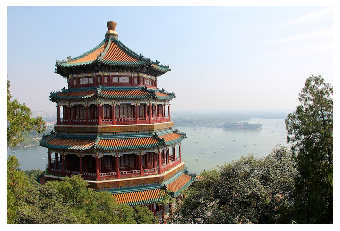

In [8]:
plot_color_image(images[0])

In [6]:
images_resized = tf.image.resize(images, [224, 224])

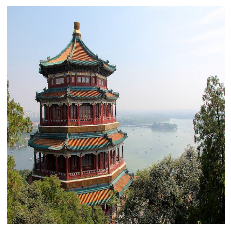

In [7]:
plot_color_image(images_resized[0])

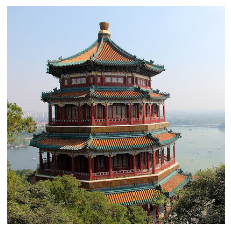

In [9]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])

In [10]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [13]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

In [14]:
y_proba = model.predict(inputs)

In [15]:
y_proba.shape

(2, 1000)

In [16]:
top_k = keras.applications.resnet50.decode_predictions(y_proba, top=3)

40960/35363 [==================================] - 0s 1us/step


In [18]:
top_k

[[('n03877845', 'palace', 0.43393642),
  ('n02825657', 'bell_cote', 0.43074432),
  ('n03781244', 'monastery', 0.11695033)],
 [('n04522168', 'vase', 0.539645),
  ('n07930864', 'cup', 0.0952412),
  ('n11939491', 'daisy', 0.04966422)]]